In [1]:
import midynet
import matplotlib.pyplot as plt
import pathlib
import numpy as np
import fractions
import pandas as pd
import time

from tqdm import notebook as tqdm
from itertools import product
from midynet.statistics import Statistics
from midynet.utility import display
from matplotlib.lines import Line2D
from matplotlib.ticker import ScalarFormatter




display.setup_dir("./")

paths_to_figures = ["."]
paths_to_figures = list(map(pathlib.Path, paths_to_figures))

# path_to_data = pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/duality/figure2/")
# path_to_data = pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/duality/figure2/")
path_to_data = pathlib.Path(f"../../scripts/duality/data/figure2")

path_to_data.exists()


True

In [2]:
dynamics = ["glauber", "sis", "cowan"] 
xrawlabels = ["coupling", "infection_prob", "nu"]
xcleanlabels = [r"J", r"\lambda", r"\nu"]
titles = ["Glauber", "SIS", "Cowan"]
recon = {}
pred = {}
xaxis = {}
auxaxis = {}

for l, d in zip(xrawlabels, dynamics):
    df = pd.read_pickle(path_to_data / f"exact-{d}/reconinfo.pkl")
    df = next(iter(df.values()))
    recon[d] = Statistics.from_dataframe(df, key="recon")
#     recon[d].rescale_(1./100)
    pred[d] = Statistics.from_dataframe(df, key="pred")
    xaxis[d] = df[f"data_model.length"].values
    auxaxis[d] = df[f"data_model.{l}"].values


  0%|          | 0/9 [00:00<?, ?it/s]

13.178659915924072


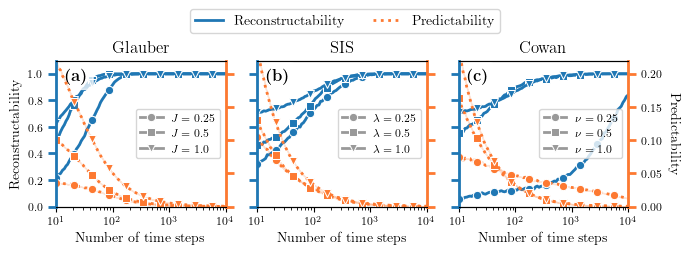

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(7, 7/3), sharex=True, sharey=False)
axx = np.array(list(map(lambda a:a.twinx(), ax)))
recon_color = display.med_colors["blue"]
pred_color = display.dark_colors["orange"]
recon_yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
pred_yticks = [0, 0.05, 0.1, 0.15, 0.2]
markers = display.markers

t0 = time.time()
pb = tqdm.tqdm(total=sum([len(np.unique(auxaxis[d])) for d in dynamics]))
for i, d in enumerate(dynamics):
    handles = []
    for j, c in enumerate(np.unique(auxaxis[d])):
        idx = auxaxis[d] == c
        recon[d].lineplot(
            xaxis[d], 
            indexes=idx, 
            color=recon_color, 
            marker=markers[j], 
            linestyle="-",
            markevery=10, 
            linewidth=2,
            ax=ax[i],
        )
        pred[d].lineplot(
            xaxis[d], 
            indexes=idx, 
            color=pred_color, 
            marker=markers[j], 
            linestyle="dotted",
            markevery=10, 
            linewidth=2,
            ax=axx[i],
        )
        handles.append(
            display.get_label_line(
                rf"${xcleanlabels[i]} = {c}$", 
                style=ax[i].get_lines()[-1], 
                color=display.light_colors["grey"]
            )
        )
        pb.update()
    ax[i].set_xscale("log")
    axx[i].set_xscale("log")
    ax[i].set_xlim([min(xaxis[d]), max(xaxis[d])])
    ax[i].set_ylim([0, 1.1])
    axx[i].set_ylim([0, 0.22])
    if i == 0:
        ax[i].set_ylabel(
            r"Reconstructability", 
            fontsize=display.fontsizes["label"], 
        )
        ax[i].set_yticks(recon_yticks)
    else:
        ax[i].set_ylabel("")
        ax[i].set_yticklabels([])
    if i == 2:
        axx[i].set_ylabel(
            r"Predictability", 
            fontsize=display.fontsizes["label"], 
            rotation=-90, 
            rotation_mode="anchor", 
            va="bottom"
        )
        axx[i].set_yticks(pred_yticks)
    else:
        axx[i].set_ylabel("")
        axx[i].set_yticklabels([])
    ax[i].set_xlabel(r"Number of time steps", fontsize=display.fontsizes["label"])
    ax[i].tick_params(axis='both', labelsize=display.fontsizes["tick"])
    ax[i].set_xticks([10, 100, 1000, 10000])
    ax[i].legend(handles=handles, loc="center right", fontsize=display.fontsizes["legend"], ncol=1, frameon=True)
    ax[i].tick_params(axis='y', color=recon_color, length=6, width=2)
    ax[i].set_title(titles[i], fontsize=display.fontsizes["large_label"])
    
    axx[i].spines['left'].set_color(recon_color)
    axx[i].spines['left'].set_linewidth(2)
    axx[i].spines['right'].set_color(pred_color)
    axx[i].spines['right'].set_linewidth(2)
    axx[i].tick_params(axis='y', color=pred_color, length=6, width=2)
    axx[i].tick_params(axis='both', labelsize=display.fontsizes["tick"])
    
           
    display.Label.plot(ax[i], loc="top left", box=True)
display.Label.clear()

handles = [
    display.get_label_line("Reconstructability", style=ax[i].get_lines()[0], marker="None"),
    display.get_label_line("Predictability", style=axx[i].get_lines()[0], marker="None"),
]
lg = fig.legend(handles=handles, loc="center", fontsize=display.fontsizes["label"], ncol=2, bbox_to_anchor=(0.5, 1.02))
fig.tight_layout()
t1 = time.time()
print(t1 - t0)

for p, fmt in product(paths_to_figures, ["svg", "pdf", "png"]):
    fig.savefig(p / f"{fmt}/exact-duality-timesteps.{fmt}", bbox_extra_artists=(lg,), bbox_inches='tight')
